<a href="https://colab.research.google.com/github/fang2020shu/TAMU-Data-Science-Competition/blob/main/Tencent_Takehome_Time_Series_Prediction_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import lightgbm as lgb
import time

In [ ]:
pip install lightgbm==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.3.0
    Uninstalling lightgbm-4.3.0:
      Successfully uninstalled lightgbm-4.3.0


In [ ]:
import lightgbm as lgb

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/Tencent_Takehome/topline_metrics.csv")
data1.shape

(477081, 14)

In [ ]:
data1.drop(data1.columns[0], axis=1, inplace=True)

In [ ]:
data1.drop_duplicates(subset = ["Date",'Platform','Country'],keep=False, inplace = True)

In [ ]:
data1.shape

(475577, 13)

In [ ]:
data1['Revenue'] = np.log1p(data1.Revenue.values)

In [ ]:
sum(data1['Revenue']==0)

37010

In [ ]:
data1.isnull().sum()

Date                    0
Platform                0
Country                 0
TRU                     0
DAU                     0
NRU                     0
Revenue                 0
Payer                   0
UC Total Outflow (K)    0
D1                      0
D7                      0
AOT(min)                0
Country_code            0
dtype: int64

In [ ]:
zero_counts = (data1 == 0).sum()
zero_counts

Date                        0
Platform                    0
Country                     0
TRU                         4
DAU                         4
NRU                     14516
Revenue                 37010
Payer                   36166
UC Total Outflow (K)        0
D1                      28376
D7                      45577
AOT(min)                    8
Country_code                0
dtype: int64

In [ ]:
data1 = data1[(data1 != 0).all(axis=1)]
data1.shape

(412735, 13)

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475577 entries, 0 to 477080
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  475577 non-null  object 
 1   Platform              475577 non-null  object 
 2   Country               475577 non-null  object 
 3   TRU                   475577 non-null  float64
 4   DAU                   475577 non-null  float64
 5   NRU                   475577 non-null  float64
 6   Revenue               475577 non-null  float64
 7   Payer                 475577 non-null  float64
 8   UC Total Outflow (K)  475577 non-null  object 
 9   D1                    475577 non-null  float64
 10  D7                    475577 non-null  float64
 11  AOT(min)              475577 non-null  float64
 12  Country_code          475577 non-null  object 
dtypes: float64(8), object(5)
memory usage: 50.8+ MB


In [ ]:
data1['UC Total Outflow (K)'] = pd.to_numeric(data1['UC Total Outflow (K)'], errors='coerce')

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412735 entries, 0 to 477080
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  412735 non-null  object 
 1   Platform              412735 non-null  object 
 2   Country               412735 non-null  object 
 3   TRU                   412735 non-null  float64
 4   DAU                   412735 non-null  float64
 5   NRU                   412735 non-null  float64
 6   Revenue               412735 non-null  float64
 7   Payer                 412735 non-null  float64
 8   UC Total Outflow (K)  359740 non-null  float64
 9   D1                    412735 non-null  float64
 10  D7                    412735 non-null  float64
 11  AOT(min)              412735 non-null  float64
 12  Country_code          412735 non-null  object 
dtypes: float64(9), object(4)
memory usage: 44.1+ MB


In [ ]:
data1['Date'] =  pd.to_datetime(data1['Date'])

In [ ]:
data1['Weekday'] = data1.Date.dt.dayofweek
data1['month'] = data1.Date.dt.month
data1['year'] = data1.Date.dt.year

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412735 entries, 0 to 477080
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  412735 non-null  datetime64[ns]
 1   Platform              412735 non-null  object        
 2   Country               412735 non-null  object        
 3   TRU                   412735 non-null  float64       
 4   DAU                   412735 non-null  float64       
 5   NRU                   412735 non-null  float64       
 6   Revenue               412735 non-null  float64       
 7   Payer                 412735 non-null  float64       
 8   UC Total Outflow (K)  359740 non-null  float64       
 9   D1                    412735 non-null  float64       
 10  D7                    412735 non-null  float64       
 11  AOT(min)              412735 non-null  float64       
 12  Country_code          412735 non-null  object        
 13 

In [ ]:
usa = data1[(data1['Country_code'] == 'USA')]
usa.shape


(2177, 16)

In [ ]:
usa.head()

,Date,Platform,Country,TRU,DAU,NRU,Revenue,Payer,UC Total Outflow (K),D1,D7,AOT(min),Country_code,Weekday,month,year
2481,2017-06-01,IOS(All),United States(美国),19399525.0,769873.0,20574.0,110047.61,7058.0,11598,49.84,22.72,87.5,USA,3,6,2017
2720,2017-06-01,ALL,United States(美国),40231111.0,1597533.0,49706.0,193720.96,12882.0,18340,51.78,22.57,97.6,USA,3,6,2017
2876,2017-06-01,Android(All),United States(美国),21777285.0,826119.0,30506.0,82746.86,5812.0,6743,53.07,22.77,106.2,USA,3,6,2017
3144,2017-06-02,ALL,United States(美国),40280496.0,1628993.0,49385.0,208955.98,13320.0,18464,51.49,23.54,96.5,USA,4,6,2017
3497,2017-06-02,IOS(All),United States(美国),19418706.0,761020.0,19181.0,113880.84,7324.0,10954,47.44,22.90,86.9,USA,4,6,2017


In [ ]:
usa_ALL = usa[usa['Platform']=='ALL']

In [ ]:
usa_ALL.shape

(725, 16)

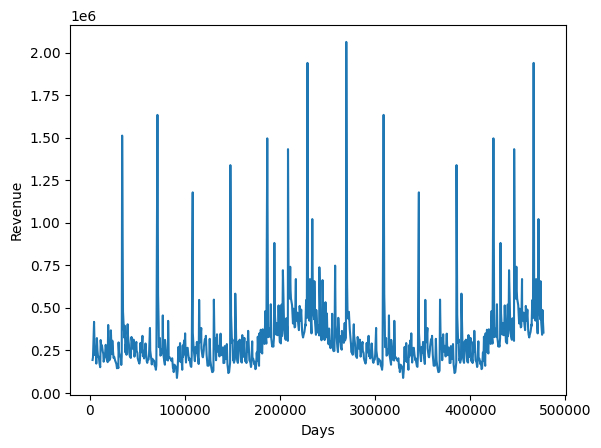

In [ ]:
plt.plot(usa_ALL['Revenue'])
plt.xlabel('Days')
plt.ylabel('Revenue')
plt.show()

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

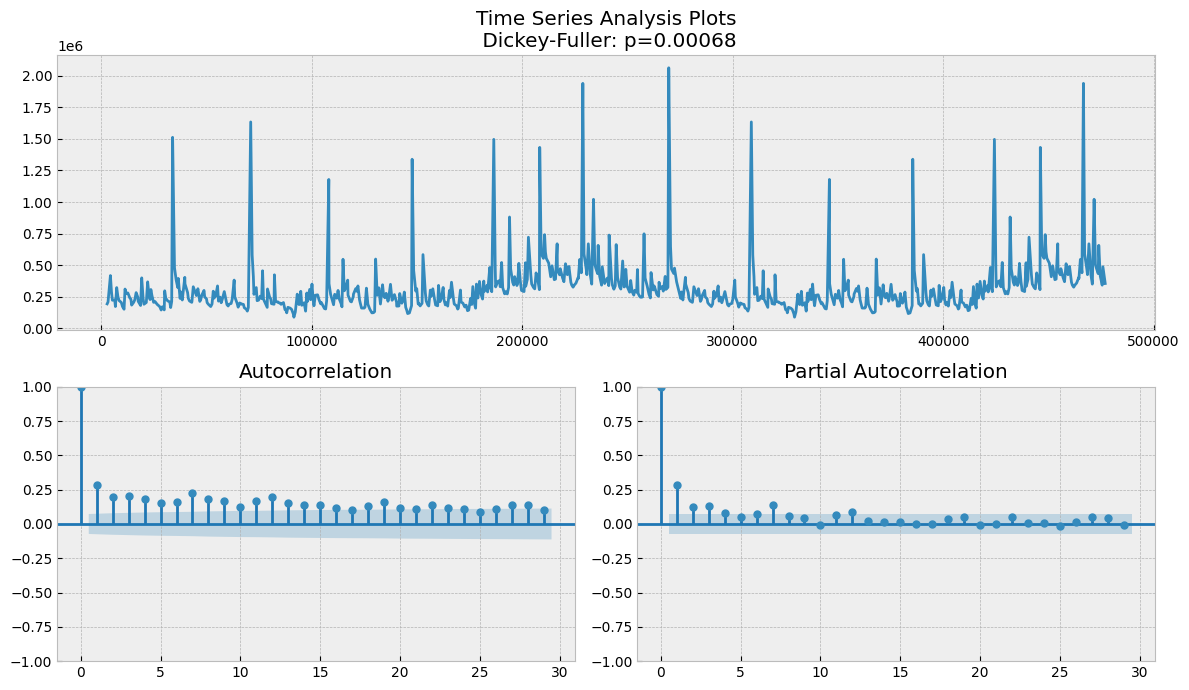

In [ ]:
tsplot(usa_ALL.Revenue)

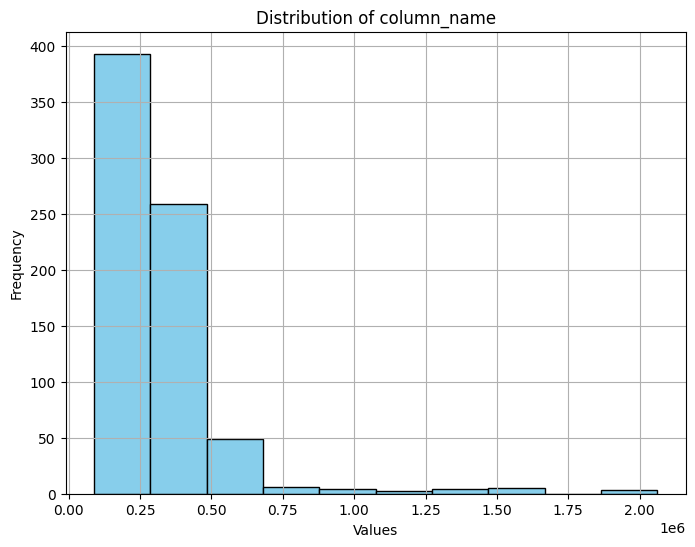

In [ ]:
rev = pd.DataFrame(usa_ALL['Revenue'])
plt.figure(figsize=(8, 6))
plt.hist(rev['Revenue'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of column_name')
plt.grid(True)
plt.show()

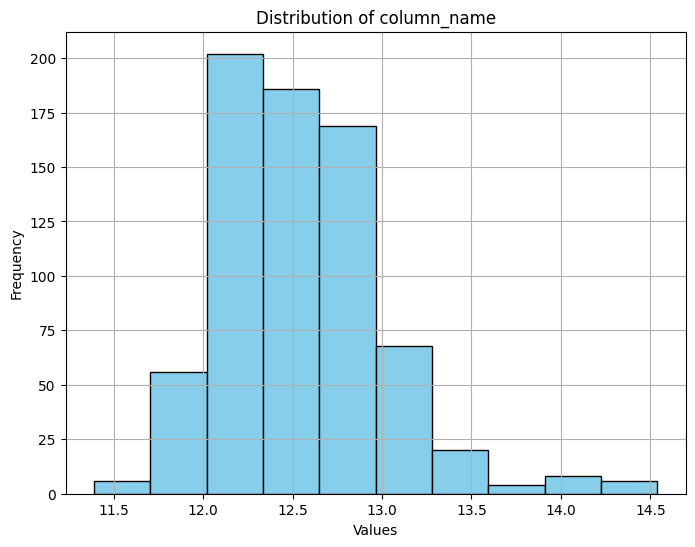

In [ ]:
rev = pd.DataFrame(usa_ALL['Revenue'])
plt.figure(figsize=(8, 6))
plt.hist(np.log(rev['Revenue']), bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of column_name')
plt.grid(True)
plt.show()

In [ ]:
# Creating lag features
def create_lag_features(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating rolling mean features
def create_rmean_features(df, gpby_cols, target_col, windows, min_periods=2, shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = gpby[target_col].shift(shift).rolling(window=w, min_periods=min_periods,win_type=win_type).mean().values +np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating rolling median features
def create_rmed_features(df, gpby_cols, target_col, windows, min_periods=2, shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = gpby[target_col].shift(shift).rolling(window=w, min_periods=min_periods,win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating exponentially weighted mean features
def create_ewm_features(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [ ]:
year_frequency = usa_ALL['year'].value_counts().reset_index()
year_frequency.columns = ['year', 'frequency']

# Calculate proportion of each year
year_frequency['proportion'] = year_frequency['frequency'] / len(usa_ALL)

print(year_frequency)

   year  frequency  proportion
0  2018        362    0.499310
1  2017        212    0.292414
2  2019        151    0.208276


In [ ]:
usa_ALL['year'].nunique()

3

In [ ]:
data1_copy = data1.copy()

In [ ]:
data1_copy = create_lag_features(data1_copy, gpby_cols=['Country_code','Platform'], target_col='Revenue',
                               lags=[151,158,165,172,179,186,193,200,207,214,221,228,235])

In [ ]:
data1_copy.head()

,Date,Platform,Country,TRU,DAU,NRU,Revenue,Payer,UC Total Outflow (K),D1,...,Revenue_lag_172,Revenue_lag_179,Revenue_lag_186,Revenue_lag_193,Revenue_lag_200,Revenue_lag_207,Revenue_lag_214,Revenue_lag_221,Revenue_lag_228,Revenue_lag_235
0,2017-06-01,Android,ALL,328115353.0,37040731.0,659119.0,1402681.83,168965.0,116232,55.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-01,IOS,ALL,100552561.0,10251221.0,134293.0,1341730.18,80891.0,143366,53.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-01,ALL,ALL,426084361.0,49280939.0,839167.0,2801595.40,255157.0,259592,53.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-06-02,ALL,ALL,426955711.0,50719801.0,871350.0,3083825.08,250595.0,270912,53.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-06-02,Android,ALL,328804991.0,38415016.0,689638.0,1608268.27,169928.0,124751,55.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data1_copy.columns

Index(['Date', 'Platform', 'Country', 'TRU', 'DAU', 'NRU', 'Revenue', 'Payer',
       'UC Total Outflow (K)', 'D1', 'D7', 'AOT(min)', 'Country_code',
       'Weekday', 'month', 'year', 'Revenue_lag_151', 'Revenue_lag_158',
       'Revenue_lag_165', 'Revenue_lag_172', 'Revenue_lag_179',
       'Revenue_lag_186', 'Revenue_lag_193', 'Revenue_lag_200',
       'Revenue_lag_207', 'Revenue_lag_214', 'Revenue_lag_221',
       'Revenue_lag_228', 'Revenue_lag_235'],
      dtype='object')

In [ ]:
data1_copy.drop(columns='Country',inplace=True)

In [ ]:
data1_copy = create_ewm_features(data1_copy, gpby_cols=['Country_code','Platform'],
                               target_col='Revenue',
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5],
                               shift=[151,158,165,172,179,186,193,200,207,214,221,228,235])

In [ ]:
data1_copy.shape

(412735, 106)

In [ ]:
def one_hot_encoder(df, ohe_cols=['Country','Platform','Weekday','month']):
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [ ]:
data1_copy = one_hot_encoder(data1_copy, ohe_cols=['Country_code','Platform','Weekday','month'])

Creating OHE features..
Old df shape:(412735, 106)
New df shape:(412735, 362)


In [ ]:
X_train = data1_copy[data1_copy['year']<2019]
X_train.head()

,Date,TRU,DAU,NRU,Revenue,Payer,UC Total Outflow (K),D1,D7,AOT(min),...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2017-06-01,328115353.0,37040731.0,659119.0,14.153897,168965.0,116232.0,55.41,27.77,127.5,...,0,0,0,1,0,0,0,0,0,0
1,2017-06-01,100552561.0,10251221.0,134293.0,14.109471,80891.0,143366.0,53.53,27.74,115.4,...,0,0,0,1,0,0,0,0,0,0
2,2017-06-01,426084361.0,49280939.0,839167.0,14.845700,255157.0,259592.0,53.83,26.64,124.5,...,0,0,0,1,0,0,0,0,0,0
3,2017-06-02,426955711.0,50719801.0,871350.0,14.941682,250595.0,270912.0,53.76,27.01,125.0,...,0,0,0,1,0,0,0,0,0,0
4,2017-06-02,328804991.0,38415016.0,689638.0,14.290669,169928.0,124751.0,55.21,28.01,127.6,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
Y_train = X_train['Revenue'].values.reshape((-1))
len(Y_train)

313453

In [ ]:
X_test = data1_copy[data1_copy['year'] == 2019]
Y_test = X_test['Revenue'].values.reshape((-1))

In [ ]:
X_test.shape, len(Y_test)

((99282, 362), 99282)

In [ ]:
avoid_cols = ['Date', 'Revenue', 'year']
cols = [col for col in X_train.columns if col not in avoid_cols]
print('No of training features: {} \nAnd they are:{}'.format(len(cols), cols))

No of training features: 359 
And they are:['TRU', 'DAU', 'NRU', 'Payer', 'UC Total Outflow (K)', 'D1', 'D7', 'AOT(min)', 'Revenue_lag_151', 'Revenue_lag_158', 'Revenue_lag_165', 'Revenue_lag_172', 'Revenue_lag_179', 'Revenue_lag_186', 'Revenue_lag_193', 'Revenue_lag_200', 'Revenue_lag_207', 'Revenue_lag_214', 'Revenue_lag_221', 'Revenue_lag_228', 'Revenue_lag_235', 'Revenue_lag_151_ewm_0.95', 'Revenue_lag_158_ewm_0.95', 'Revenue_lag_165_ewm_0.95', 'Revenue_lag_172_ewm_0.95', 'Revenue_lag_179_ewm_0.95', 'Revenue_lag_186_ewm_0.95', 'Revenue_lag_193_ewm_0.95', 'Revenue_lag_200_ewm_0.95', 'Revenue_lag_207_ewm_0.95', 'Revenue_lag_214_ewm_0.95', 'Revenue_lag_221_ewm_0.95', 'Revenue_lag_228_ewm_0.95', 'Revenue_lag_235_ewm_0.95', 'Revenue_lag_151_ewm_0.9', 'Revenue_lag_158_ewm_0.9', 'Revenue_lag_165_ewm_0.9', 'Revenue_lag_172_ewm_0.9', 'Revenue_lag_179_ewm_0.9', 'Revenue_lag_186_ewm_0.9', 'Revenue_lag_193_ewm_0.9', 'Revenue_lag_200_ewm_0.9', 'Revenue_lag_207_ewm_0.9', 'Revenue_lag_214_ewm_0.9

In [ ]:
X_train.head()

,Date,TRU,DAU,NRU,Revenue,Payer,UC Total Outflow (K),D1,D7,AOT(min),...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2017-06-01,328115353.0,37040731.0,659119.0,1402681.83,168965.0,116232,55.41,27.77,127.5,...,0,0,0,1,0,0,0,0,0,0
1,2017-06-01,100552561.0,10251221.0,134293.0,1341730.18,80891.0,143366,53.53,27.74,115.4,...,0,0,0,1,0,0,0,0,0,0
2,2017-06-01,426084361.0,49280939.0,839167.0,2801595.40,255157.0,259592,53.83,26.64,124.5,...,0,0,0,1,0,0,0,0,0,0
3,2017-06-02,426955711.0,50719801.0,871350.0,3083825.08,250595.0,270912,53.76,27.01,125.0,...,0,0,0,1,0,0,0,0,0,0
4,2017-06-02,328804991.0,38415016.0,689638.0,1608268.27,169928.0,124751,55.21,28.01,127.6,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# LightGBM parameters
lgb_params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression',
              'metric': {'mae'}, 'num_leaves': 10, 'learning_rate': 0.02,
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0,
              'num_boost_round':15000, 'early_stopping_rounds':200, 'nthread':-1}

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376291 entries, 0 to 378232
Columns: 363 entries, Date to month_12
dtypes: datetime64[ns](1), float64(99), int64(1), object(1), uint8(261)
memory usage: 389.4+ MB


In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns


In [ ]:
object_columns

Index([], dtype='object')

In [ ]:
# Creating lgbtrain & lgbval
lgbtrain = lgb.Dataset(data=X_train.loc[:,cols].values, label=Y_train,
                       feature_name=cols)
lgbval = lgb.Dataset(data=X_test.loc[:,cols].values, label=Y_test,
                     reference=lgbtrain, feature_name=cols)

In [ ]:
def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
def lgb_validation(params, lgbtrain, lgbval, X_test, Y_test, verbose_eval):
    t0 = time.time()
    evals_result = {}
    model = lgb.train(params, lgbtrain, num_boost_round=params['num_boost_round'],
                      valid_sets=[lgbtrain, lgbval], feval=lgbm_smape,
                      early_stopping_rounds=params['early_stopping_rounds'],
                      evals_result=evals_result, verbose_eval=verbose_eval)
    print(model.best_iteration)
    print('Total time taken to build the model: ', (time.time()-t0)/60, 'minutes!!')
    pred_Y_test = model.predict(X_test, num_iteration=model.best_iteration)
    pred_Y_test = np.expm1(pred_Y_test)
    Y_test = np.expm1(Y_test)
    test_df = pd.DataFrame(columns=['true_Y_test','pred_Y_test'])
    test_df['pred_Y_test'] = pred_Y_test
    test_df['true_Y_test'] = Y_test

    print('SMAPE for validation data is:{}'.format(smape(pred_Y_test, Y_test)))
    return model, test_df

In [ ]:
# Training lightgbm model and validating
model, val_df = lgb_validation(lgb_params, lgbtrain, lgbval, X_test.loc[:,cols].values,
                               Y_test, verbose_eval=500)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:261: UserWarn

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.403418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.283841	training's SMAPE: 27.6557	valid_1's l1: 0.217295	valid_1's SMAPE: 21.4172
[1000]	training's l1: 0.262765	training's SMAPE: 25.6794	valid_1's l1: 0.200732	valid_1's SMAPE: 19.8128
[1500]	training's l1: 0.252618	training's SMAPE: 24.7266	valid_1's l1: 0.194155	valid_1's SMAPE: 19.1748
[2000]	training's l1: 0.246389	training's SMAPE: 24.1432	valid_1's l1: 0.190656	valid_1's SMAPE: 18.8367
[2500]	training's l1: 0.242095	training's SMAPE: 23.7443	valid_1's l1: 0.188056	valid_1's SMAPE: 18.5851
[3000]	training's l1: 0.239013	training's SMAPE: 23.4603	valid_1's l1: 0.186341	valid_1's

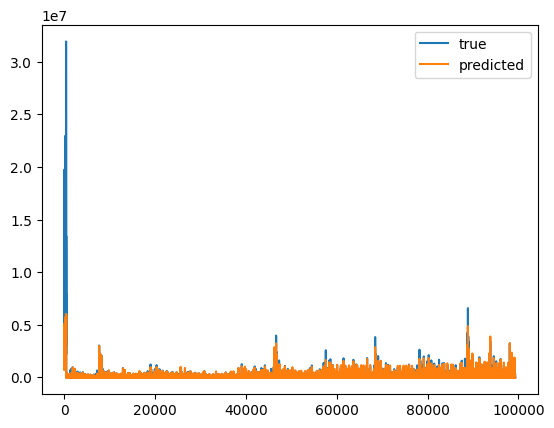

In [ ]:
plt.plot(val_df['true_Y_test'], label = 'true')
plt.plot(val_df['pred_Y_test'], label = 'predicted')
plt.legend(loc = 'best')
# plt.ylabel(VAR)
plt.show()

In [ ]:
val_timeframe

,Date,Platform,Country,TRU,DAU,NRU,Revenue,Payer,UC Total Outflow (K),D1,D7,AOT(min),Country_code,Weekday,month,year
378259,2019-01-01,ALL,United States(美国),49531609.0,1219511.0,47402.0,12.077204,11686.0,10637.0,41.86,18.78,112.9,USA,1,1,2019
378604,2019-01-01,Android(All),United States(美国),27720027.0,669037.0,28458.0,11.102747,5449.0,3541.0,42.35,19.12,120.8,USA,1,1,2019
378794,2019-01-01,IOS,United States(美国),23088065.0,548143.0,20540.0,11.589728,6210.0,7096.0,41.48,18.86,102.3,USA,1,1,2019
378960,2019-01-02,IOS,United States(美国),23107256.0,545626.0,19289.0,11.600851,5330.0,6764.0,41.25,17.54,102.5,USA,2,1,2019
379303,2019-01-02,ALL,United States(美国),49580404.0,1229799.0,48893.0,12.083426,9528.0,9989.0,40.89,16.81,111.5,USA,2,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476184,2019-05-30,Android(All),United States(美国),32381703.0,834551.0,28053.0,11.947498,7750.0,8711.0,39.27,18.43,140.9,USA,3,5,2019
476415,2019-05-30,IOS,United States(美国),25699530.0,639725.0,18517.0,12.701712,10542.0,29246.0,40.71,18.26,117.2,USA,3,5,2019
476592,2019-05-31,Android(All),United States(美国),32413932.0,842975.0,32327.0,11.725660,6873.0,6668.0,32.42,15.46,139.7,USA,4,5,2019
476635,2019-05-31,IOS,United States(美国),25717196.0,635069.0,17764.0,12.339773,9141.0,16137.0,39.58,18.89,116.5,USA,4,5,2019


In [ ]:
val_timeframe = data1[(data1['year'] == 2019)].reset_index()

In [ ]:
del val_timeframe['index']

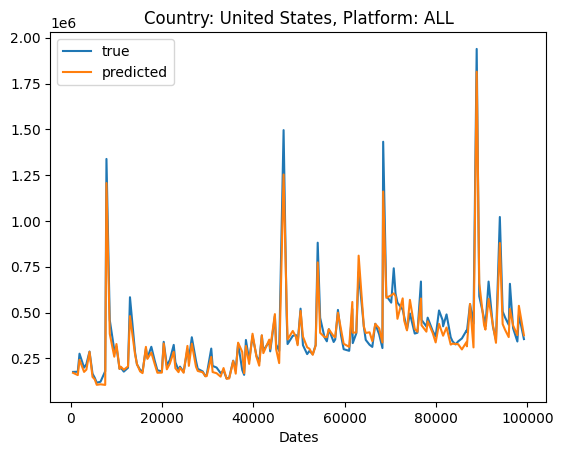

In [ ]:
idx = val_timeframe[(val_timeframe['Country_code'] == 'USA') & (val_timeframe['Platform'] == 'ALL')]['Revenue'].index
plt.plot(val_df.loc[idx,'true_Y_test'], label = 'true')
plt.plot(val_df.loc[idx,'pred_Y_test'], label = 'predicted')
plt.xlabel('Dates')
# plt.ylabel(VAR)
plt.title('Country: United States, Platform: ALL')
plt.legend(loc = 'best')
plt.show()